In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

from stable_fluid.fluid import Fluid
from IPython.display import display, clear_output

RESOLUTION = 500, 500
DURATION = 20000

INFLOW_PADDING = 50
INFLOW_DURATION = 600000
INFLOW_RADIUS = 8
INFLOW_VELOCITY = 0.2
INFLOW_COUNT = 5



In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device: ", device)
fluid = Fluid(RESOLUTION, 'dye')

center = np.floor_divide(RESOLUTION, 2)
r = np.min(center) - INFLOW_PADDING

points = np.linspace(-np.pi, np.pi, INFLOW_COUNT, endpoint=False)
# (x, y) 좌표들...
points = tuple(np.array((np.cos(p), np.sin(p))) for p in points)
normals = tuple(-p for p in points)
points = tuple(r * p + center for p in points)

inflow_velocity = np.zeros_like(fluid.velocity.cpu().numpy())
inflow_dye = np.zeros(fluid.shape)
for p, n in zip(points, normals):
    mask = np.linalg.norm(fluid.indices.cpu().numpy() - p[:, None, None], axis=0) <= INFLOW_RADIUS
    inflow_velocity[:, mask] += n[:, None] * INFLOW_VELOCITY
    inflow_dye[mask] = 1

inflow_velocity = torch.from_numpy(inflow_velocity).to(device)
inflow_dye = torch.from_numpy(inflow_dye).to(device)

device:  cuda


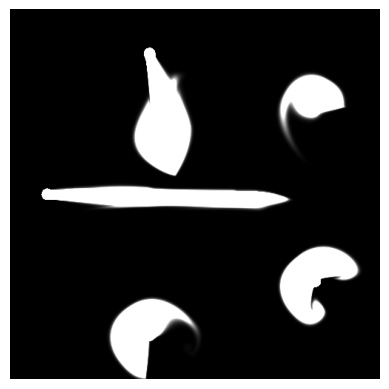

Computing frame 876 of 20000.


In [ ]:
plt.ioff()  # interactive mode 끄기
fig, ax = plt.subplots()
im = ax.imshow(np.zeros(RESOLUTION), cmap='gray', vmin=0, vmax=1)
plt.axis('off')

for f in range(DURATION):
    print(f'Computing frame {f + 1} of {DURATION}.')
    if f <= INFLOW_DURATION:
        fluid.velocity += inflow_velocity
        fluid.dye += inflow_dye
    fluid.step(dt=0.2)
    
    color = np.dstack((fluid.dye.cpu().numpy(), fluid.dye.cpu().numpy(), fluid.dye.cpu().numpy()))
    color = (np.clip(color, 0, 1) * 255).astype('uint8')
    
    im.set_data(color)
    clear_output(wait=True)
    fig.canvas.draw_idle()
    display(fig)
    